<a href="https://colab.research.google.com/github/cweidig/measuring_bias/blob/main/measure_bias_3preprocess_1reweighing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# read the file mortgage_data_project.pkl from Google drive with pandas' read_pickle()
import pandas as pd
import seaborn as sns
import numpy as np

# Load the datset into a pandas dataframe
from joblib import load

df = load("/content/drive/My Drive/mortgage_data_preprocessed.pkl.gz")

In [43]:
df.head()

,loan_amount_000s,applicant_income_000s,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,applicant_ethnicity_name_Hispanic or Latino,applicant_ethnicity_name_Not Hispanic or Latino,...,property_type_name_Manufactured housing,property_type_name_One-to-four family dwelling (other than manufactured housing),loan_purpose_name_Home improvement,loan_purpose_name_Home purchase,loan_purpose_name_Refinancing,loan_type_name_Conventional,loan_type_name_FHA-insured,loan_type_name_FSA/RHS-guaranteed,loan_type_name_VA-guaranteed,action_taken_name
0,102,151.0,5972.0,1.890000,66600.0,106.129997,1973.0,2194.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,False
1,114,30.0,4188.0,4.660000,49500.0,106.169998,1331.0,3113.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,False
2,105,112.0,9565.0,42.529999,61200.0,100.330002,2504.0,3149.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,False
3,270,182.0,5928.0,9.990000,67400.0,170.520004,1755.0,2102.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,False
4,62,36.0,4021.0,3.560000,54200.0,139.789993,1296.0,1487.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,False


In [ ]:
# install AIF360
# !pip install aif360
# !pip install fairlearn
# !pip install 'aif360[inFairness]'

In [37]:
# Set up the fairness metrics to be computed using AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
#from aif360.metrics import ClassificationMetric

privileged_group = [{'applicant_sex_name_Female': 0}]
unprivileged_group = [{'applicant_sex_name_Female': 1}]

In [42]:
# Create an object of type Reweighing and store it in a variable called rw.

# Use the reweighing subjects technique

# Create a Binary Label Dataset from the training data

dataset = BinaryLabelDataset(df=df, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])

from aif360.algorithms.preprocessing import Reweighing

rw = Reweighing(unprivileged_group, privileged_group)

dataset_transformed = rw.fit_transform(dataset)

In [ ]:
# View the resulting dataset with sample weights allocated
dataset_transformed

In [46]:
# Convert the result to a more general format

df = dataset_transformed.convert_to_dataframe()[0]
instance_weights = dataset_transformed.instance_weights

In [47]:
 # Create a BinaryLabelDatasetMetric

metric_transformed = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_group, privileged_group)

In [63]:
# Use metric_transformed to get the Disparate Impact and Statistical Parity Difference metrics for the transformed dataset.

disparte_impact_metric = metric_transformed.disparate_impact()

statistical_parity_difference = metric_transformed.statistical_parity_difference()

metrics = ['Disparate Impact','Stat. Parity Diff.']
values = [disparte_impact_metric, statistical_parity_difference]

metrics_df = pd.DataFrame({"Metric": metrics,
                   "Value": values})

metrics_df

,Metric,Value
0,Disparate Impact,1.0
1,Stat. Parity Diff.,0.0


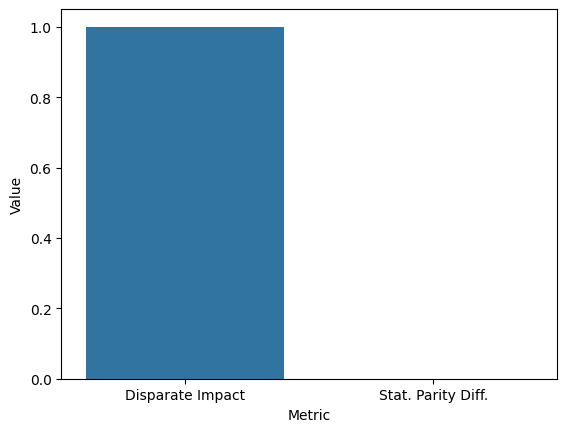

In [68]:
# Chart the metrics

import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x="Metric", y="Value", data=metrics_df)
plt.show()


<ipython-input-67-0a842f5e61c3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(metrics_df, x='Value', y='Metric', inner='stick', palette='Dark2')


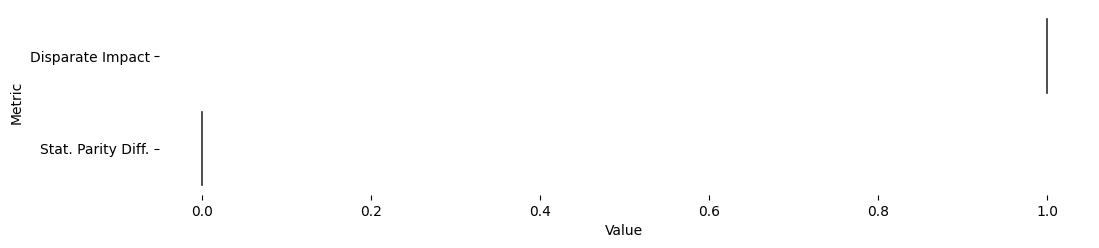

In [ ]:
# @title Metric vs Value

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(metrics_df['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(metrics_df, x='Value', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)